In [2]:
import numpy as np

import torch
from torch import nn

import wandb

import matplotlib.pyplot as plt
from tqdm import tqdm, trange

In [3]:
def gen_data(n: int):
    scale = 4.
    centers = np.array([
        [1, 0],
        [-1, 0],
        [0, 1],
        [0, -1],
        [1. / np.sqrt(2), 1. / np.sqrt(2)],
        [1. / np.sqrt(2), -1. / np.sqrt(2)],
        [-1. / np.sqrt(2), 1. / np.sqrt(2)],
        [-1. / np.sqrt(2), -1. / np.sqrt(2)]
    ])
    centers = scale * centers

    x = np.random.randn(n, 2)
    x = 0.5 * x

    center_ids = np.random.randint(0, 8, n)
    x = x + centers[center_ids]

    x = x / 2 ** 0.5

    x = x.astype(np.float32)

    return x

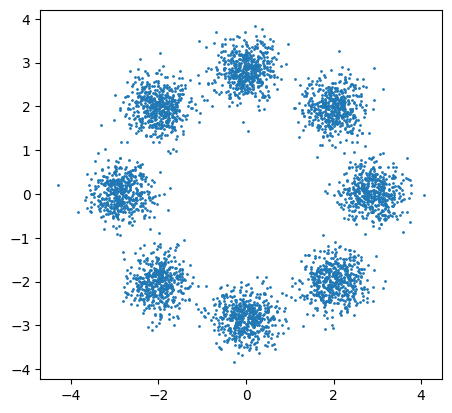

In [4]:
data_sample = gen_data(2 ** 12)

plt.scatter(data_sample[:, 0], data_sample[:, 1], s=1)
plt.axis("scaled")
plt.show()

In [5]:
class Net(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.SELU(),
            nn.Linear(64, 64),
            nn.SELU(),
            nn.Linear(64, 64),
            nn.SELU(),
            nn.Linear(64, 64),
            nn.SELU(),
            nn.Linear(64, out_dim),
        )
        
    def forward(self, t):
        return self.net(t)

In [6]:
class Affine(nn.Module):
    """
    Affine transformation module. It parametrizes the forward
    process of the diffusion model with a Gaussian distribution.

    F(x, t, eps) = \mu(x, t) + \sigma(x, t) * eps
    """

    def __init__(self):
        super().__init__()
        
        #the net used to predict the mean and std_bar in the gaussian parameterization
        self.net = Net(3, 4)
        
    def forward(self, x, t):
        # Conditional optimal transport (FM-OT)
        # return (1 - t) * x, t + (1 - t) * 0.01

        # Learnable Gaussian forward process (NFDM-Gaussian)
        x_t = torch.cat([x, t], dim=1)
        m_ls = self.net(x_t) 
        m, ls = m_ls.chunk(2, dim=1)

        
        print("m: ", m.shape)
        print("ls: ", ls.shape)
        print("x: ", x.shape)
        print("t: ", t.shape)
        print("mul", (1 - t) * x)
        print("mul2", t * (1 - t) * m)

        m = (1 - t) * x + t * (1 - t) * m #m is mu_hat
        ls = (1 - t) * np.log(0.01) + t * (1 - t) * ls #ls is log(sigma_hat) so the final expresion is log sigma. 
        #0.01 is delta, so delta^2 = 0.0001 like in the paper

        return m, torch.exp(ls)

In [7]:
#this class corresponds to x_theta(z_t, t), I will decouple it so that the predicted x can also be use elsewhere. in my case it will be predicted e but okay. 
class Predictor(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = Net(3, 2) #transformer in my case 
        
    def forward(self, z, t):
        z_t = torch.cat([z, t], dim=1)
        x = self.net(z_t)

        # Reparametrization for numerical stability
        x = (1 - t) * z + (t + 0.01) * x
        
        return x

In [8]:
class Volatility(nn.Module):
    """
    Volatility module. It parametrizes the volatility g of the reverse and forward processes.

    d z = f(z, t) d t + g(t) d \bar{w}_t
                        ^^^^
    """
    def __init__(self):
        super().__init__()
        
        self.net = Net(1, 1) #in the paper this is a three layer MLP 
        self.sp = nn.Softplus()
        
    def forward(self, t):
        # Volatility, that corresponds to linear log-SNR schedule in DDPM/VDM
        # return (20 * torch.sigmoid(-10 + 20 * t)) ** 0.5

        # Learnable volatility
        return self.sp(self.net(t))

In [9]:
import torch
import torch.autograd
import torch.autograd.functional
def jvp(f, x, v):
    return torch.autograd.functional.jvp(
        f, x, v, 
        create_graph=torch.is_grad_enabled()
    )

def t_dir(f, t):
    return jvp(f, t, torch.ones_like(t))

In [10]:
class NeuralDiffusion(nn.Module):
    def __init__(self, affine, pred, vol):
        super().__init__()
        
        self.affine = affine
        self.pred = pred
        self.vol = vol
        
    def forward(self, x, t):
        def f(x_in):
            def f_(t_in):
                return self.affine(x_in, t_in)
            return f_

        g2 = self.vol(t) ** 2

        # compute parameters of q(z_t | x) and corresponding time derivatives
        (f_m, f_s), (f_dm, f_ds) = t_dir(f(x), t) #(function output), (jvp) == (mean, sigma), (mean derivative, sigma derivative)

        # sample z_t from q(z_t | x)
        # z_t should obtained from putting epsilon into the forward process
        eps = torch.randn_like(x)
        z = f_m + f_s * eps # function evaluation of F(x, t, eps)

        # compute the drift term of the forward process based on eps
        # f_drift is what is then used in the loss and is the forward process drift.
        f_dz = f_dm + f_ds * eps  # ODE drift ---> this works because gaussians are nice and linear so the derivative of F(x, t, eps) can be written like this. 
        f_score = - eps / f_s  # score function
        f_drift = f_dz - 0.5 * g2 * f_score  # SDE drift 

        # predict x from z_t
        x_ = self.pred(z, t)

        # substitute predicted \hat{x} into the forward process to parameterise the reverse process
        (r_m, r_s), (r_dm, r_ds) = t_dir(f(x_), t)

        # compute the drift term of the reverse process based on z_t
        r_dz = r_dm + r_ds / r_s * (z - r_m)  # ODE drift
        r_score = (r_m - z) / r_s ** 2  # score function
        r_drift = r_dz - 0.5 * g2 * r_score  # SDE drift

        # compute the diffusion loss
        loss = 0.5 * (f_drift - r_drift) ** 2 / g2
        loss = loss.sum(dim=1)
        
        return loss

In [11]:
def train(model):
    optim = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    wandb.init(project="public_diffusion")

    for _ in trange(10 ** 5):
        x = torch.tensor(gen_data(2 ** 10))
        t = torch.rand(x.shape[0], 1) #sample a t for each example in the batch
        
        loss = model(x, t).mean()
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        wandb.log({"loss": loss.item()})

In [12]:
affine = Affine()
pred = Predictor()
vol = Volatility()
ndm = NeuralDiffusion(affine, pred, vol)

In [14]:
train(ndm)

  0%|          | 6/100000 [00:00<29:24, 56.67it/s]

m:  torch.Size([1024, 2])
ls:  torch.Size([1024, 2])
x:  torch.Size([1024, 2])
t:  torch.Size([1024, 1])
mul tensor([[ 0.5801, -0.0366],
        [-1.2328, -2.1047],
        [-0.5763,  1.6319],
        ...,
        [-2.1005, -0.1131],
        [-0.3191, -0.3675],
        [-0.0116, -0.0189]], grad_fn=<MulBackward0>)
mul2 tensor([[ 0.1736,  0.0145],
        [-0.0769, -0.0980],
        [-0.0575,  0.1156],
        ...,
        [-0.1317, -0.0527],
        [-0.1207, -0.1333],
        [-0.0063, -0.0087]], grad_fn=<MulBackward0>)
m:  torch.Size([1024, 2])
ls:  torch.Size([1024, 2])
x:  torch.Size([1024, 2])
t:  torch.Size([1024, 1])
mul tensor([[ 0.4928,  0.3672],
        [-1.2278, -2.0973],
        [-0.5304,  1.6252],
        ...,
        [-2.1589, -0.1176],
        [-0.2476, -0.3872],
        [-0.0122, -0.0292]], grad_fn=<MulBackward0>)
mul2 tensor([[ 0.1659,  0.1429],
        [-0.0768, -0.0978],
        [-0.0537,  0.1160],
        ...,
        [-0.1338, -0.0532],
        [-0.1034, -0.1373],
 

  0%|          | 18/100000 [00:00<29:37, 56.24it/s]

m:  torch.Size([1024, 2])
ls:  torch.Size([1024, 2])
x:  torch.Size([1024, 2])
t:  torch.Size([1024, 1])
mul tensor([[-0.1379,  1.0466],
        [ 0.8925, -1.5760],
        [ 1.3598,  1.5465],
        ...,
        [-0.0146, -0.0154],
        [-1.7468,  0.2179],
        [ 0.9766,  1.0334]], grad_fn=<MulBackward0>)
mul2 tensor([[-0.0168,  0.1283],
        [-0.0189, -0.1481],
        [ 0.1730,  0.1807],
        ...,
        [-0.0071, -0.0084],
        [-0.2657, -0.1134],
        [ 0.1360,  0.1317]], grad_fn=<MulBackward0>)
m:  torch.Size([1024, 2])
ls:  torch.Size([1024, 2])
x:  torch.Size([1024, 2])
t:  torch.Size([1024, 1])
mul tensor([[ 0.1665,  1.1830],
        [ 0.8911, -1.7163],
        [ 1.2767,  1.3795],
        ...,
        [ 0.0283, -0.0018],
        [-1.6113, -0.0037],
        [ 0.7861,  1.0857]], grad_fn=<MulBackward0>)
mul2 tensor([[ 0.0562,  0.1866],
        [-0.0206, -0.1561],
        [ 0.1529,  0.1536],
        ...,
        [ 0.0099,  0.0007],
        [-0.2586, -0.1404],
 

  0%|          | 30/100000 [00:00<30:16, 55.04it/s]


m:  torch.Size([1024, 2])
ls:  torch.Size([1024, 2])
x:  torch.Size([1024, 2])
t:  torch.Size([1024, 1])
mul tensor([[-2.0090e+00,  2.0794e+00],
        [ 1.2737e+00,  1.1512e+00],
        [ 2.2359e-01,  1.7184e-01],
        ...,
        [-2.0288e+00,  2.3132e+00],
        [-1.5343e+00, -1.3515e+00],
        [ 2.4961e+00,  1.5018e-03]], grad_fn=<MulBackward0>)
mul2 tensor([[-0.0083,  0.0026],
        [ 0.2178,  0.2160],
        [ 0.0917,  0.0800],
        ...,
        [-0.0414,  0.0212],
        [-0.2702, -0.2666],
        [ 0.1265, -0.0012]], grad_fn=<MulBackward0>)
m:  torch.Size([1024, 2])
ls:  torch.Size([1024, 2])
x:  torch.Size([1024, 2])
t:  torch.Size([1024, 1])
mul tensor([[-2.0421,  2.1166],
        [ 1.2469,  0.8878],
        [ 0.0245,  0.2750],
        ...,
        [-2.0503,  2.2490],
        [-1.4788, -1.1381],
        [ 2.4104,  0.0107]], grad_fn=<MulBackward0>)
mul2 tensor([[-0.0084,  0.0027],
        [ 0.1953,  0.1589],
        [ 0.0293,  0.0944],
        ...,
        

  0%|          | 42/100000 [00:00<31:11, 53.40it/s]

m:  torch.Size([1024, 2])
ls:  torch.Size([1024, 2])
x:  torch.Size([1024, 2])
t:  torch.Size([1024, 1])
mul tensor([[ 0.3764, -0.4674],
        [ 0.1630,  2.6784],
        [ 0.3535,  0.4068],
        ...,
        [-1.7580, -1.2364],
        [ 0.6875,  0.1447],
        [ 0.0583, -0.8714]], grad_fn=<MulBackward0>)
mul2 tensor([[ 0.0778, -0.1683],
        [ 0.0399,  0.2009],
        [ 0.1311,  0.1680],
        ...,
        [-0.2487, -0.1910],
        [ 0.2214,  0.0965],
        [-0.0815, -0.2687]], grad_fn=<MulBackward0>)
m:  torch.Size([1024, 2])
ls:  torch.Size([1024, 2])
x:  torch.Size([1024, 2])
t:  torch.Size([1024, 1])
mul tensor([[ 0.0252, -0.3406],
        [ 0.1898,  2.5313],
        [ 0.4994, -0.0845],
        ...,
        [-1.6773, -0.9928],
        [ 0.3432, -0.1040],
        [-0.4692, -0.9497]], grad_fn=<MulBackward0>)
mul2 tensor([[-0.0566, -0.1464],
        [ 0.0359,  0.1890],
        [ 0.1418, -0.0149],
        ...,
        [-0.2423, -0.1698],
        [ 0.0709, -0.0422],
 

  0%|          | 54/100000 [00:00<30:48, 54.07it/s]

m:  torch.Size([1024, 2])
ls:  torch.Size([1024, 2])
x:  torch.Size([1024, 2])
t:  torch.Size([1024, 1])
mul tensor([[-1.1287,  1.0069],
        [-1.9047, -1.5463],
        [-0.0392,  0.8271],
        ...,
        [ 0.5012,  0.0544],
        [ 1.9923,  2.2485],
        [-2.0514,  0.1603]], grad_fn=<MulBackward0>)
mul2 tensor([[-0.2592,  0.1577],
        [-0.1819, -0.1582],
        [ 0.0185,  0.2755],
        ...,
        [ 0.2067,  0.0681],
        [ 0.0235,  0.0314],
        [-0.2997, -0.0645]], grad_fn=<MulBackward0>)
m:  torch.Size([1024, 2])
ls:  torch.Size([1024, 2])
x:  torch.Size([1024, 2])
t:  torch.Size([1024, 1])
mul tensor([[-1.0962,  0.6210],
        [-1.9863, -1.5027],
        [ 0.5673,  0.4769],
        ...,
        [ 0.1547,  0.3387],
        [ 1.9946,  2.2742],
        [-1.9429,  0.0972]], grad_fn=<MulBackward0>)
mul2 tensor([[-0.2873,  0.0583],
        [-0.1868, -0.1563],
        [ 0.2027,  0.2151],
        ...,
        [ 0.0741,  0.1538],
        [ 0.0236,  0.0318],
 

  0%|          | 66/100000 [00:01<31:08, 53.49it/s]

m:  torch.Size([1024, 2])
ls:  torch.Size([1024, 2])
x:  torch.Size([1024, 2])
t:  torch.Size([1024, 1])
mul tensor([[-1.5972, -0.2639],
        [ 0.4940,  2.8160],
        [-0.0035, -0.1177],
        ...,
        [-2.2571,  0.4716],
        [-1.8660, -2.0211],
        [ 1.1832, -1.6433]], grad_fn=<MulBackward0>)
mul2 tensor([[-0.4698, -0.1627],
        [ 0.0101,  0.0724],
        [-0.0176, -0.0738],
        ...,
        [-0.1486, -0.0150],
        [-0.0068, -0.0066],
        [ 0.1023, -0.2841]], grad_fn=<MulBackward0>)
m:  torch.Size([1024, 2])
ls:  torch.Size([1024, 2])
x:  torch.Size([1024, 2])
t:  torch.Size([1024, 1])
mul tensor([[-1.5941, -0.5822],
        [ 0.5297,  2.8288],
        [-0.1334,  0.1874],
        ...,
        [-2.3092,  0.4768],
        [-1.8853, -2.0603],
        [ 1.0621, -1.3648]], grad_fn=<MulBackward0>)
mul2 tensor([[-0.4652, -0.2291],
        [ 0.0114,  0.0732],
        [-0.0544,  0.0895],
        ...,
        [-0.1512, -0.0146],
        [-0.0069, -0.0066],
 

  0%|          | 78/100000 [00:01<30:17, 54.98it/s]

m:  torch.Size([1024, 2])
ls:  torch.Size([1024, 2])
x:  torch.Size([1024, 2])
t:  torch.Size([1024, 1])
mul tensor([[ 1.9239,  1.8756],
        [ 0.3780,  0.5117],
        [-1.2098, -0.9947],
        ...,
        [ 0.0788, -0.0181],
        [-0.0098,  1.0733],
        [-0.1466,  2.4588]], grad_fn=<MulBackward0>)
mul2 tensor([[ 0.2006,  0.2524],
        [ 0.1024,  0.2109],
        [-0.4633, -0.3718],
        ...,
        [ 0.0488, -0.0077],
        [ 0.0057,  0.4717],
        [-0.0231,  0.1010]], grad_fn=<MulBackward0>)
m:  torch.Size([1024, 2])
ls:  torch.Size([1024, 2])
x:  torch.Size([1024, 2])
t:  torch.Size([1024, 1])
mul tensor([[ 1.7317,  1.7024],
        [ 0.0104, -0.7941],
        [-1.1434, -1.1372],
        ...,
        [ 0.0739, -0.0431],
        [-0.1384,  0.7957],
        [-0.1604,  2.4259]], grad_fn=<MulBackward0>)
mul2 tensor([[ 0.1726,  0.2232],
        [-0.0761, -0.3701],
        [-0.4346, -0.4091],
        ...,
        [ 0.0454, -0.0276],
        [-0.0856,  0.3213],
 

  0%|          | 84/100000 [00:01<32:22, 51.43it/s]

m:  torch.Size([1024, 2])
ls:  torch.Size([1024, 2])
x:  torch.Size([1024, 2])
t:  torch.Size([1024, 1])
mul tensor([[-0.4695,  0.5572],
        [ 1.3609,  1.9296],
        [-2.9557, -0.2466],
        ...,
        [ 0.4783, -0.4101],
        [ 0.4836, -0.9399],
        [ 0.7169,  1.3223]], grad_fn=<MulBackward0>)
mul2 tensor([[-0.2682,  0.1978],
        [ 0.0322,  0.0653],
        [-0.0110, -0.0029],
        ...,
        [ 0.2298, -0.2484],
        [ 0.2143, -0.4884],
        [ 0.2828,  0.5548]], grad_fn=<MulBackward0>)
m:  torch.Size([1024, 2])
ls:  torch.Size([1024, 2])
x:  torch.Size([1024, 2])
t:  torch.Size([1024, 1])
mul tensor([[-0.0978, -0.1043],
        [-1.4829, -1.4319],
        [ 0.4913,  2.8920],
        ...,
        [-1.4876, -1.6089],
        [ 0.5038,  0.3441],
        [ 0.9905,  0.0600]], grad_fn=<MulBackward0>)
mul2 tensor([[-0.0757, -0.0777],
        [-0.0581, -0.0522],
        [ 0.0047,  0.0363],
        ...,
        [-0.3075, -0.3059],
        [ 0.2467,  0.2202],
 

  0%|          | 96/100000 [00:01<33:42, 49.39it/s]

m:  torch.Size([1024, 2])
ls:  torch.Size([1024, 2])
x:  torch.Size([1024, 2])
t:  torch.Size([1024, 1])
mul tensor([[ 0.0346,  2.6007],
        [-0.0191,  0.2365],
        [-0.0878, -2.3929],
        ...,
        [ 2.1507,  0.0580],
        [ 1.7173,  0.2130],
        [ 0.0704,  0.5349]], grad_fn=<MulBackward0>)
mul2 tensor([[-0.0105,  0.1215],
        [-0.0086,  0.1926],
        [-0.0491, -0.1933],
        ...,
        [ 0.2529, -0.0030],
        [ 0.5602,  0.1082],
        [ 0.0674,  0.3933]], grad_fn=<MulBackward0>)
m:  torch.Size([1024, 2])
ls:  torch.Size([1024, 2])
x:  torch.Size([1024, 2])
t:  torch.Size([1024, 1])
mul tensor([[ 0.0135,  2.6081],
        [ 0.2817, -0.0319],
        [-0.1449, -2.3690],
        ...,
        [ 2.1986,  0.0752],
        [ 1.7810, -0.0057],
        [-0.2629,  0.4965]], grad_fn=<MulBackward0>)
mul2 tensor([[-0.0114,  0.1218],
        [ 0.2125, -0.0047],
        [-0.0536, -0.1912],
        ...,
        [ 0.2611,  0.0009],
        [ 0.5726,  0.0247],
 

  0%|          | 106/100000 [00:02<33:47, 49.28it/s]

m:  torch.Size([1024, 2])
ls:  torch.Size([1024, 2])
x:  torch.Size([1024, 2])
t:  torch.Size([1024, 1])
mul tensor([[ 0.7354,  0.0105],
        [ 1.2383,  0.6571],
        [-1.2595, -1.1647],
        ...,
        [-1.1982,  1.4103],
        [-1.2646,  1.0408],
        [ 0.7908,  1.0223]], grad_fn=<MulBackward0>)
mul2 tensor([[ 0.4675,  0.0507],
        [ 0.5300,  0.3777],
        [-0.4983, -0.4511],
        ...,
        [-0.4685,  0.4440],
        [-0.5003,  0.2750],
        [ 0.3644,  0.5451]], grad_fn=<MulBackward0>)
m:  torch.Size([1024, 2])
ls:  torch.Size([1024, 2])
x:  torch.Size([1024, 2])
t:  torch.Size([1024, 1])
mul tensor([[ 0.1009, -0.1030],
        [ 0.1558,  0.5514],
        [-1.0136, -0.8569],
        ...,
        [-0.5710,  1.7155],
        [-1.5153,  1.2922],
        [ 0.3412,  0.9721]], grad_fn=<MulBackward0>)
mul2 tensor([[-0.0135, -0.1156],
        [-0.0258,  0.1805],
        [-0.4272, -0.3593],
        ...,
        [-0.2356,  0.5857],
        [-0.5470,  0.3508],
 

  0%|          | 108/100000 [00:02<32:11, 51.71it/s]


mul2 tensor([[ 0.6062, -0.0651],
        [-0.0199, -0.2063],
        [-0.3617, -0.4650],
        ...,
        [-0.3261, -0.0823],
        [-0.5055,  0.2723],
        [-0.0235, -0.0188]], grad_fn=<MulBackward0>)


KeyboardInterrupt: 

In [ ]:
@torch.no_grad()
def solve_sde(sde, z, ts, tf, n_steps):
    bs = z.shape[0]
    
    tt = torch.linspace(ts, tf, n_steps + 1)[:-1]
    dt = (tf - ts) / n_steps
    dt_2 = abs(dt) ** 0.5
    
    path = [z]
    for t in tqdm(tt):
        t = t.expand(bs, 1)
        
        f, g = sde(z, t)
        w = torch.randn_like(z)
        z = z + f * dt + g * w * dt_2
        
        path.append(z)
        
    return z, torch.stack(path)

100%|██████████| 300/300 [00:03<00:00, 98.37it/s] 


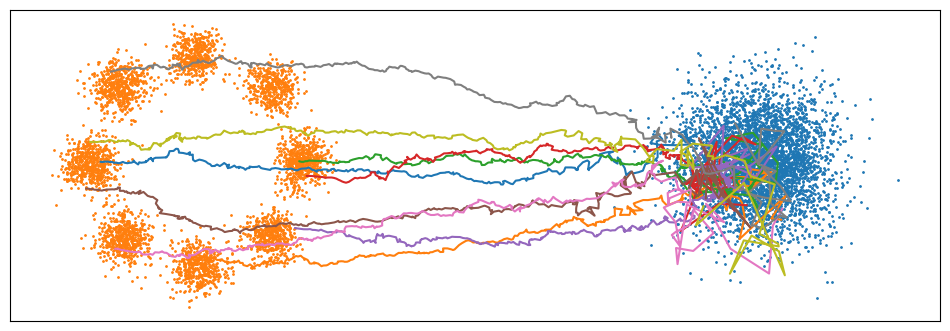

In [ ]:
def sde_drift(z, t):
    x = pred(z, t)

    def f(t_in):
        return affine(x, t_in)

    (m, s), (dm, ds) = t_dir(f, t)
    g = vol(t)
    g2 = g ** 2

    dz = dm + ds / s * (z - m)
    score = (m - z) / s ** 2
    drift = dz - 0.5 * g2 * score

    return drift, g

z_1 = torch.randn(2 ** 12, 2)
_, z_path = solve_sde(sde_drift, z_1, 1, 0, 300)

t_steps = torch.linspace(1, 0, 301)

plt.figure(figsize=(12, 12))
plt.scatter(15 + z_path[0, :, 0], z_path[0, :, 1], s=1)
plt.scatter(z_path[-1, :, 0], z_path[-1, :, 1], s=1)
plt.plot(15 * t_steps[:, None] + z_path[:, :9, 0], z_path[:, :9, 1])
plt.axis("scaled")
plt.tick_params(left=False, labelleft=False,
                bottom=False, labelbottom=False)
plt.show()

100%|██████████| 300/300 [00:02<00:00, 134.29it/s]


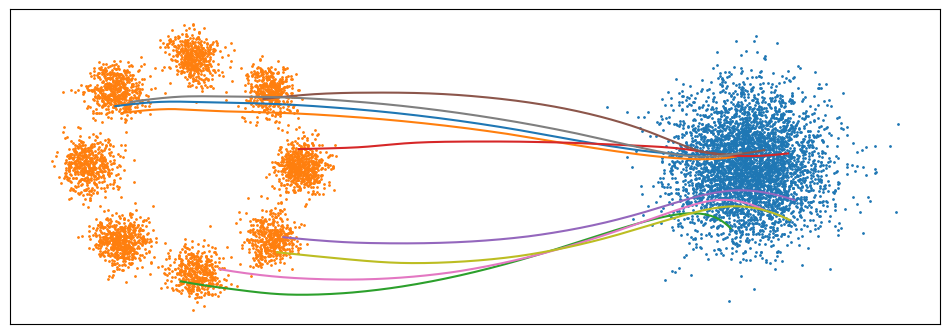

In [ ]:
def ode_drift(z, t):
    x = pred(z, t)

    def f(t_in):
        return affine(x, t_in)

    (m, s), (dm, ds) = t_dir(f, t)

    dz = dm + ds / s * (z - m)

    return dz, 0

z_1 = torch.randn(2 ** 12, 2)
_, z_path = solve_sde(ode_drift, z_1, 1, 0, 300)

t_steps = torch.linspace(1, 0, 301)

plt.figure(figsize=(12, 12))
plt.scatter(15 + z_path[0, :, 0], z_path[0, :, 1], s=1)
plt.scatter(z_path[-1, :, 0], z_path[-1, :, 1], s=1)
plt.plot(15 * t_steps[:, None] + z_path[:, :9, 0], z_path[:, :9, 1])
plt.axis("scaled")
plt.tick_params(left=False, labelleft=False,
                bottom=False, labelbottom=False)
plt.show()